## Data

In [14]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz

In [15]:
%run knn_util

<Figure size 640x480 with 0 Axes>

In [16]:
#import the tables
movieDF = pd.read_csv("files/movie.csv")
ratingDF = pd.read_csv("files/rating.csv")

In [17]:
#quick inspection of the dataframe shows the following
movieDF.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
len(ratingDF)

20000263

In [19]:
#quick inspection of the dataframe shows the following
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [34]:
num_users = len(ratingDF.userId.unique())
num_items = len(ratingDF.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 138493 unique users and 26744 unique movies in this data set


## EDA

In [36]:
ratingDFCntTmp = pd.DataFrame(ratingDF.groupby('rating').size(), columns=['count'])
ratingDFCntTmp

,count
rating,
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


Text(0, 0.5, 'number of ratings')

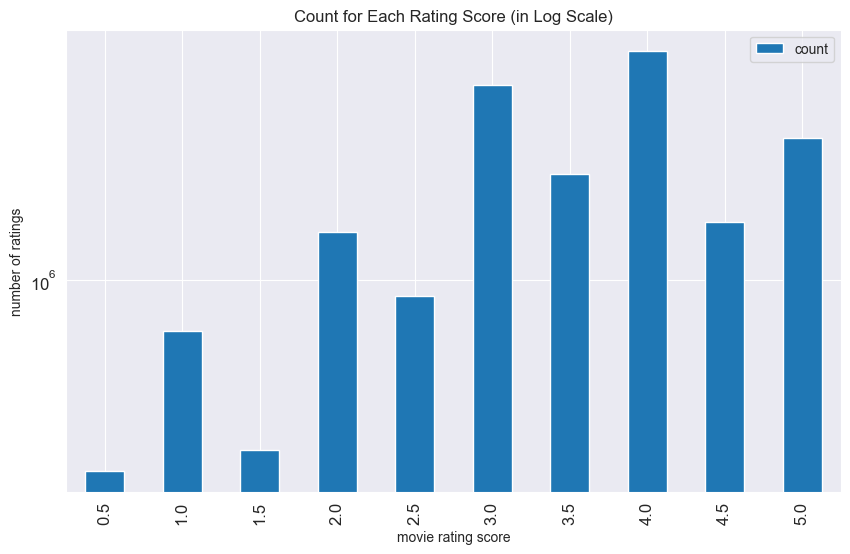

In [40]:
ax = ratingDFCntTmp[['count']].reset_index().rename(columns={'index': 'rating'}).plot(
    x='rating',
    y='count',
    kind='bar',
    figsize=(10, 6),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

## Data Filtering

In [20]:
len(ratingDF)
tempRatingDF = ratingDF.groupby("movieId", as_index=False)
print(tempRatingDF.count())
#noticed that there are movies who received 1 total rating

       movieId  userId  rating  timestamp
0            1   49695   49695      49695
1            2   22243   22243      22243
2            3   12735   12735      12735
3            4    2756    2756       2756
4            5   12161   12161      12161
...        ...     ...     ...        ...
26739   131254       1       1          1
26740   131256       1       1          1
26741   131258       1       1          1
26742   131260       1       1          1
26743   131262       1       1          1

[26744 rows x 4 columns]


<AxesSubplot:xlabel='movieId', ylabel='rating'>

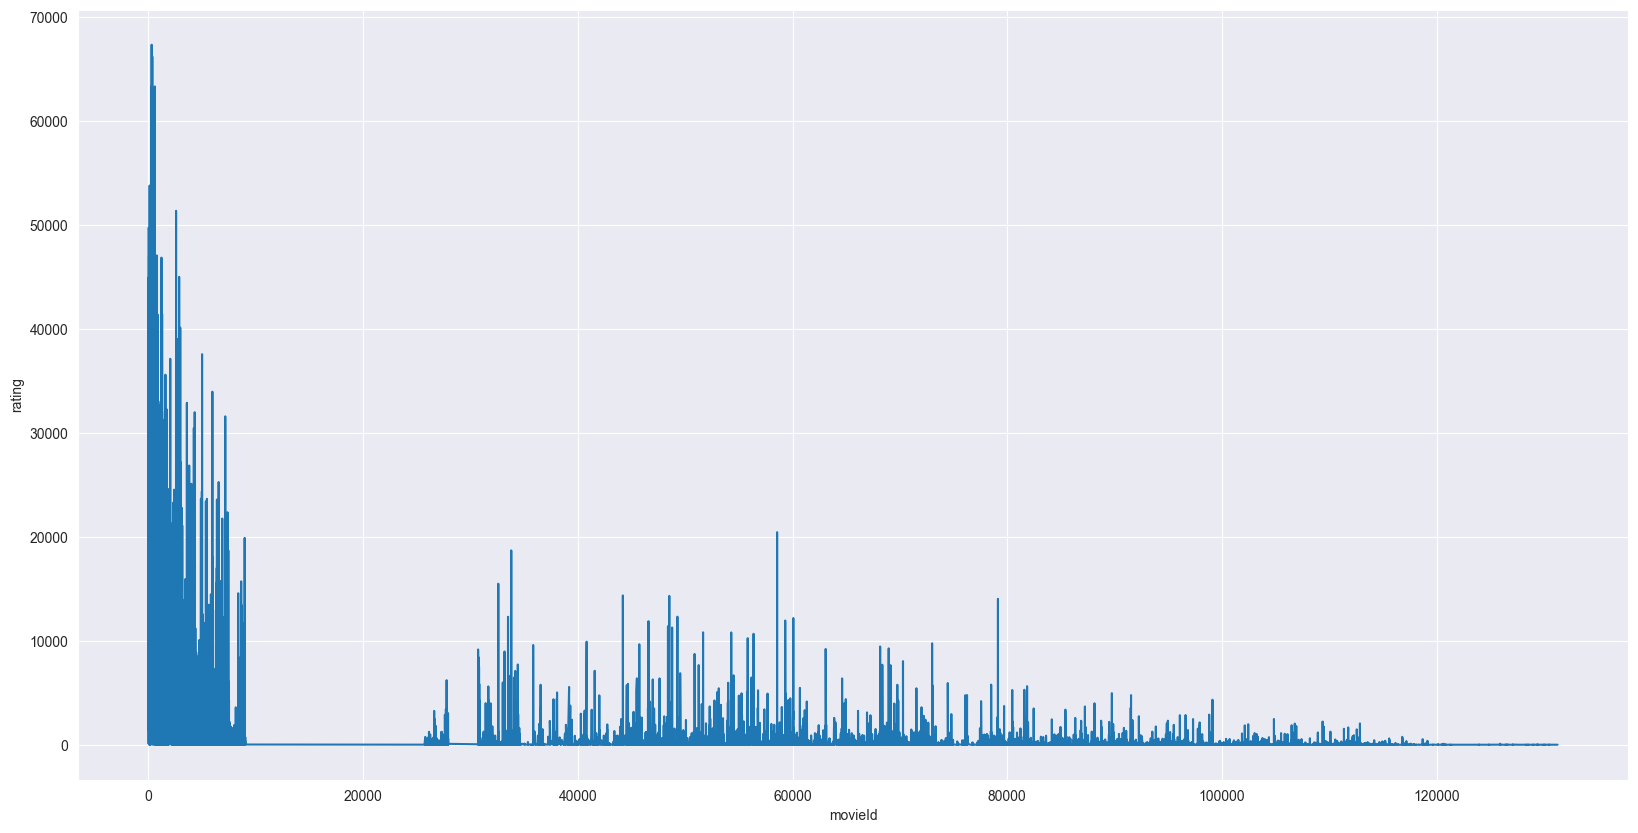

In [21]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
sns.lineplot(data = tempRatingDF.count(), y="rating", x="movieId")

In [22]:
#filter movies that are rated with less than 100 users
tempRatingDF = tempRatingDF.count()
tempRatingDFA = tempRatingDF[tempRatingDF['rating'] > 100]

In [23]:
#check the count of user id filtered on movied rated with more than 100 users
len(tempRatingDFA.groupby('userId').count())

3323

In [24]:
len(tempRatingDFA.groupby('movieId').count())

8532

In [25]:
#create list of the tempratingDFA to be used in a new table needed for the filtered movies with less than 100 ratings from users
ratingMovieList = tempRatingDFA['movieId'].tolist()
filteredRatingDF = ratingDF[ratingDF.movieId.isin(ratingMovieList)]
# len(filteredRatingDF)

<AxesSubplot:xlabel='movieId', ylabel='rating'>

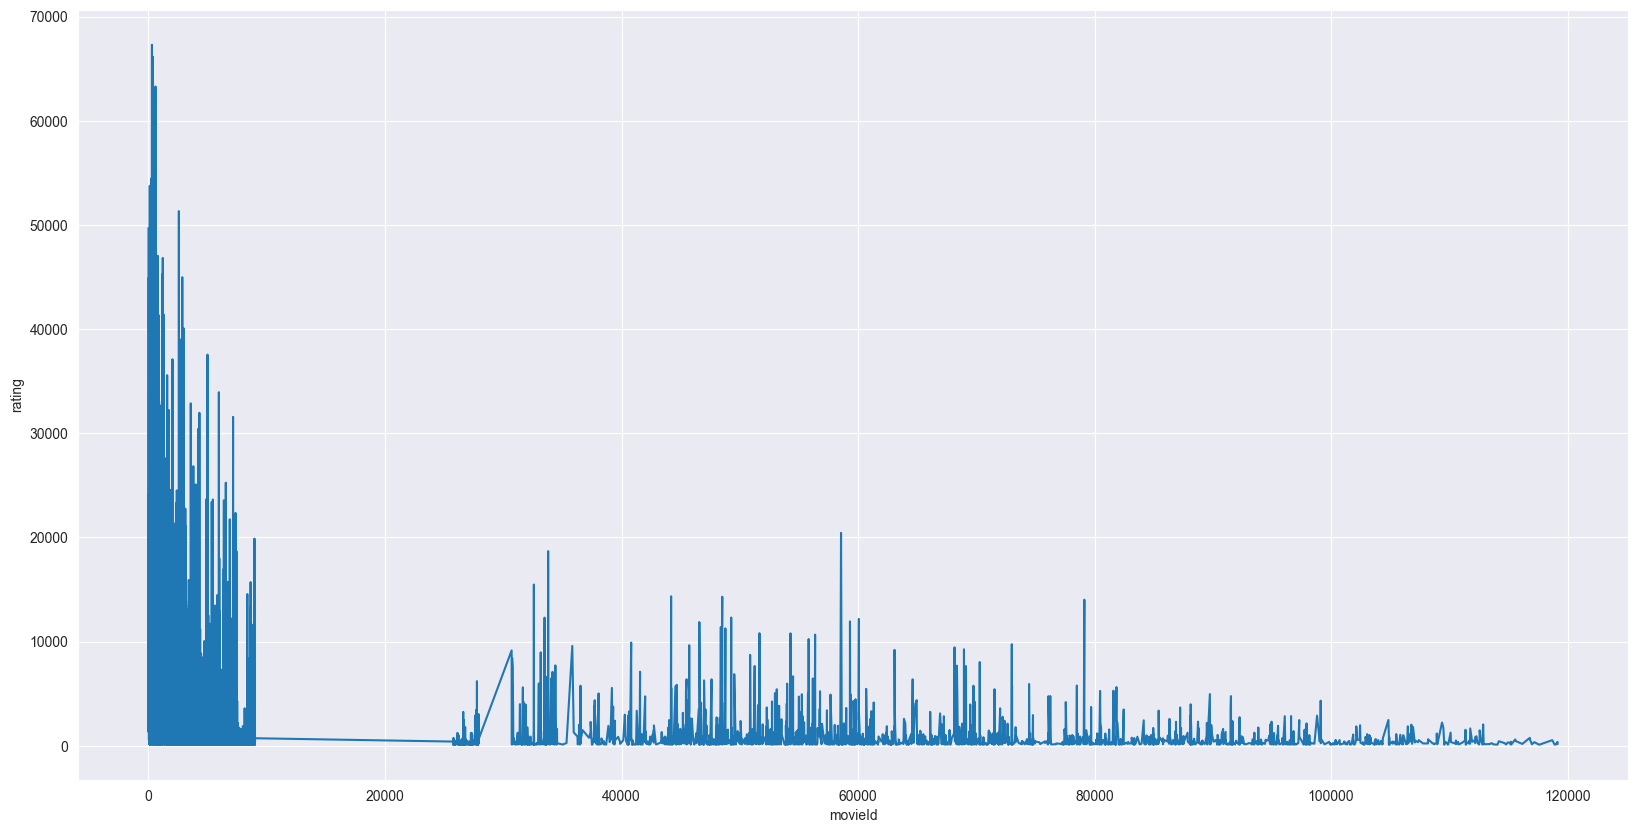

In [48]:
tempCntDF = filteredRatingDF.groupby('movieId', as_index=False)
#check the figure again
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
sns.lineplot(data = tempCntDF.count(), y="rating", x="movieId")

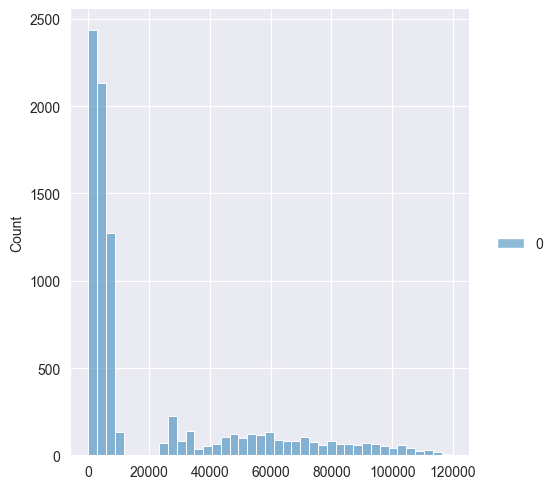

In [49]:
sns.displot(tempCntDF)

## Modeling

In [26]:
# pivot ratings into user features
movieFeaturesDF = filteredRatingDF.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [27]:
movieFeaturesDF.head()

userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.0,0.0,5.0,0.0,3.0,0.0,0.0,2.0,0.0,3.5
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# convert dataframe of movie features to scipy sparse matrix
movieFeaturesMatrix = csr_matrix(movieFeaturesDF.values)

In [29]:
movieFeaturesMatrix

<8532x138493 sparse matrix of type '<class 'numpy.float64'>'
	with 19704881 stored elements in Compressed Sparse Row format>

## Try the recommender

In [30]:
modelKnn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [50]:
movieIndexed = {
    movie: i for i, movie in 
    enumerate(list(movieDF.set_index('movieId').loc[movieFeaturesDF.index].title))
}

In [32]:
modelKnn.fit(movieFeaturesMatrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [33]:
%run knn_util
baseMovie = 'Matrix, The'

make_recommendation(
    model=modelKnn,
    data=movieFeaturesMatrix,
    movie=baseMovie,
    mapper=movieIndexed,
    n_recommendations=5)

You have input movie: Matrix, The
Found possible matches in our database: ['Matrix, The (1999)', 'Animatrix, The (2003)', 'Master, The (2012)', 'Marine, The (2006)', 'Matador, The (2005)', 'Patriot, The (2000)']

Recommendation system start to make inference
......

Recommendations for Matrix, The:
1: Men in Black (a.k.a. MIB) (1997), with distance of 0.36607811881266583
2: Sixth Sense, The (1999), with distance of 0.3483300560341348
3: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.34051120565317694
4: Fight Club (1999), with distance of 0.33842528591659327
5: Lord of the Rings: The Fellowship of the Ring, The (2001), with distance of 0.3361630247453865


<Figure size 640x480 with 0 Axes>